### BDT Spark Streaming - HW02

#### Assignment

From the data stream, implement a stream processing application that will monitor the delay
of traffic -> where delays are fastest decreasing. Detect the locations where the most traffic 
"spikes" occur repeatedly.

Input: Stream
Output: GPS coordinates of the "fastest delay minimization" locations, dashboard map 
showing these locations

In [0]:
%pip install osmnx
%pip install numpy==1.23.0

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.1
    Uninstalling numpy-1.24.1:
      Successfully uninstalled numpy-1.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.1 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.0 which is incompatible.
Python interpreter will be restarted.


#### Data selection

I chose to process only data from trams stream, but pretty much the same approach could be applied on other vehicle types. Either separately, or tables could be merged and processed all together.

In [0]:
%sql
DROP TABLE IF EXISTS trams_delays;
CREATE TABLE trams_delays AS
SELECT 
  ROW_NUMBER() OVER(PARTITION BY trip_id ORDER BY timestamp ASC) as trip_msg_order,
  *
FROM
(SELECT 
  cast(properties.last_position.origin_timestamp as timestamp) as timestamp,
  properties.trip.gtfs.trip_id as trip_id,
  cast(geometry.coordinates[0] as double) AS x,
  cast(geometry.coordinates[1] as double) AS y,
  properties.last_position.delay.actual as delay
FROM trams);

-- This query assigns order in which each message was generated for each trip. And also selects crutial information that will be needed later on.
-- I do this so I can compute delay decrement between two consecutive locations for each trip.

num_affected_rows,num_inserted_rows


In [0]:
%sql
SELECT
  count(*) as count,
  MIN(delay_delta) as min_delta,
  x, y
FROM
  (SELECT
      T2.x, T2.y,
      (T2.delay - T1.delay) AS delay_delta 
  FROM
  trams_delays T1, trams_delays T2
  WHERE (T1.trip_msg_order + 1) = T2.trip_msg_order and T1.trip_id = T2.trip_id
  ORDER BY delay_delta ASC)
WHERE delay_delta < -100       -- i.e. select locations where delay decreased and set arbitrary threshold (at least 100s improvement in delay)
GROUP BY x, y
ORDER BY count DESC
LIMIT 3;

-- In this query delay improvement between each recorded point of each trip is calculated. 
-- Then only top three places where delay decreased most often are selected

count,min_delta,x,y
202,-154,14.40278,50.0719
108,-122,14.32531,50.093
62,-169,14.39935,50.09346


In [0]:
# save results to pandas dataframe
df_results = _sqldf.toPandas()

In [0]:
import osmnx as ox

custom_filter='["highway"~"motorway|motorway_link|trunk|trunk_link|primary|primary_link|secondary|secondary_link|road|road_link"]'
G = ox.graph_from_place("Praha, Czechia", custom_filter=custom_filter)

/databricks/python/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


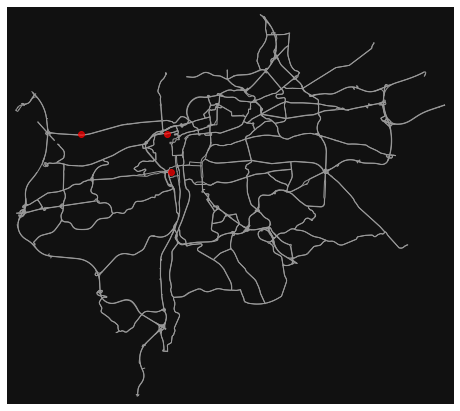

In [0]:
# plot results on map

import matplotlib.pyplot as plt
fig, ax = ox.plot_graph(G, show=False, close=False, node_size=0)
x = df_results['x']
y = df_results['y']
ax.scatter(x, y, c='red', alpha=.7)
plt.show()